In [1]:
from torchvision.datasets import CIFAR100
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from torch.autograd import Variable
from torch.utils.data import DataLoader
import copy
from PIL import Image
import torch.optim as optim

## Dataset

In [2]:
class Cifar100(CIFAR100):

    def __init__(self, root = 'Dataset', classes=range(10), train=True, transform=None, target_transform=None, download=True):

        super(Cifar100, self).__init__(root, train=train, transform=transform, target_transform=target_transform, download=download)

        # Select subset of classes 
        data = []
        targets = []

        for i in range(len(self.data)):
            if self.targets[i] in classes:
                data.append(self.data[i])
                targets.append(self.targets[i])

        self.data = np.array(data)
        self.targets = targets


    def __getitem__(self, index):
        
        img, target = self.data[index], self.targets[index]
       
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return index, img, target

    def __len__(self):
        
        return len(self.data)

    def get_image_class(self, label):
        return self.data[np.array(self.targets) == label]

    def append(self, images, labels):
        self.data = np.concatenate((self.data, images), axis=0)
        self.targets = self.targets + labels

## Resnet implementation PyTorch

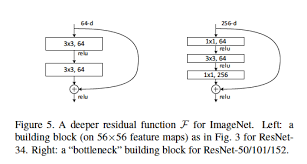

In [3]:
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo

In [4]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

In [5]:
class BasicBlock(nn.Module):

    expansion = 1
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        # In the ResNet architecture, downsampling is used to reduce the spatial dimensions of feature maps 
        # within the residual blocks. This downsampling is achieved through either the stride parameter in the 
        # convolutional layers or the presence of a downsampling branch in the form of a 1x1 convolutional layer in the Bottleneck blocks. 
        # Downsampling allows ResNet to capture hierarchical features at different scales and enables the network to learn representations of increasing 
        # complexity as the spatial dimensions decrease.
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [6]:
class Bottleneck(nn.Module):
    expansion = 4
    #  This class represents a bottleneck residual block in ResNet. 
    # It is similar to the BasicBlock but includes an additional convolutional layer (conv3) and batch normalization (bn3). 
    # The Bottleneck block is used when the number of input and output channels differ. 
    # It reduces the dimensionality using a 1x1 convolution before the 3x3 convolution and then expands it back using another 1x1 convolution. 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

In [7]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=10):
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    # create layer with multiple blocks
    # checks if downsampling is needied
    # if yes apply 1x1 conv and batch normalization
    # if no creates a sequence of blocks using given block type, number of plane and number of blocks
    # block type : basic block or bottle neck
    # planes the number of output channels by conv layer within each block
    # Number of blocks refers to the repetition of a specific type of block
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, features = False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        if features:
            x = x / x.norm()
        else:
            x = self.fc(x)

        return x

In [8]:
def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model


In [9]:
def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

In [10]:
def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model


## Finetuning

In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 100
BATCH_SIZE = 128
CLASSES_BATCH =10
STEPDOWN_EPOCHS = [49, 63]
STEPDOWN_FACTOR = 5
LR = 2
MOMENTUM = 0.9
WEIGHT_DECAY = 0.00001
NUM_EPOCHS = 70

In [ ]:
parameters = {
    'name': 'Finetuning',
    'NUM_CLASSES': NUM_CLASSES,
    'BATCH_SIZE' : BATCH_SIZE,
    'CLASSES_BATCH' : CLASSES_BATCH,
    'STEPDOWN_EPOCHS' : STEPDOWN_EPOCHS,
    'STEPDOWN_FACTOR' : STEPDOWN_FACTOR,
    'LR' : LR,
    'MOMENTUM' : MOMENTUM,
    'WEIGHT_DECAY' : WEIGHT_DECAY,
    'NUM_EPOCHS' : NUM_EPOCHS
}


In [ ]:
def test(net, test_dataloader, n_classes=100):
  criterion = nn.BCEWithLogitsLoss()

  net.to(DEVICE)
  net.train(False)

  running_loss = 0.0
  running_corrects = 0
  for index, images, labels in test_dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    labels_hot=torch.eye(n_classes,device = DEVICE)[labels]
    labels_hot = labels_hot.to(DEVICE)

    # Forward Pass
    outputs = net(images)

    # Get predictions
    _, preds = torch.max(outputs.data, 1)
    loss = criterion(outputs, labels_hot)

    # statistics
    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(preds == labels.data).data.item()

  # Calculate average losses
  epoch_loss = running_loss / float(len(test_dataloader.dataset))
  # Calculate Accuracy
  accuracy = running_corrects / float(len(test_dataloader.dataset))

  return accuracy, epoch_loss

In [ ]:

#train function
def train(net, train_dataloader, test_dataloader, n_classes=100):

  criterion = nn.BCEWithLogitsLoss()
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

  train_accuracies = []
  train_losses = []
  test_accuracies = []
  test_losses = []
  best_net = []
  best_accuracy = 0

  net.to(DEVICE)

  for epoch in range(NUM_EPOCHS):

    if epoch in STEPDOWN_EPOCHS:
      for param_group in optimizer.param_groups:
        param_group['lr'] = param_group['lr']/STEPDOWN_FACTOR

    running_loss = 0.0
    running_corrects_train = 0

    for index, inputs, labels in train_dataloader:
      inputs = inputs.to(DEVICE)
      labels = labels.to(DEVICE)
      
      labels_hot=torch.eye(n_classes,device = DEVICE)[labels]
      labels_hot = labels_hot.to(DEVICE)

      net.train(True)
      # zero the parameter gradients
      optimizer.zero_grad()
      # forward
      outputs = net(inputs)
      _, preds = torch.max(outputs, 1)
      loss = criterion(outputs, labels_hot)
      loss.backward()
      optimizer.step()

      # statistics
      running_loss += loss.item() * inputs.size(0)
      running_corrects_train += torch.sum(preds == labels.data).data.item()

    # Calculate average losses
    epoch_loss = running_loss / float(len(train_dataloader.dataset))
    # Calculate accuracy
    epoch_acc = running_corrects_train / float(len(train_dataloader.dataset))

    epoch_test_accuracy, epoch_test_loss = test(net, test_dataloader)
    
    if epoch % 10 == 0 or epoch == (NUM_EPOCHS-1):
      print('Epoch {} train Loss:{:.4f} train Accuracy:{:.4f}'.format(epoch, epoch_loss, epoch_acc))
      print('Epoch {} test Loss:{:.4f} test Accuracy:{:.4f}'.format(epoch, epoch_test_loss, epoch_test_accuracy))
      for param_group in optimizer.param_groups:
        print('Learning rate:{}'.format(param_group['lr']))
      print('-'*30)


    train_accuracies.append(epoch_acc)
    train_losses.append(epoch_loss)
    test_accuracies.append(epoch_test_accuracy)
    test_losses.append(epoch_test_loss)

    if epoch_test_accuracy > best_accuracy:
      best_accuracy = epoch_test_accuracy
      best_net = copy.deepcopy(net) 

  return best_net, train_accuracies, train_losses, test_accuracies, test_losses

In [ ]:
def incremental_learning():

  # Define transforms for training phase
  transform_train = transforms.Compose([
                                        transforms.RandomCrop(32, padding=4),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])
  transform_test = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                      ])

  net = resnet32(num_classes=NUM_CLASSES)

  new_acc_train_list = []
  new_loss_train_list = []
  new_acc_test_list = []
  new_loss_test_list = []
  all_acc_list = []
 
  for i in range(int(NUM_CLASSES/CLASSES_BATCH)):

    print('-'*30)
    print(f'**** ITERATION {i+1} ****')
    print('-'*30)

    print('Loading the Datasets ...')
    print('-'*30)

    train_dataset = Cifar100(classes=range(i*10, (i + 1)*10), train=True, transform=transform_train)
    test_dataset = Cifar100(classes=range(i*10, (i + 1)*10), train=False, transform=transform_test)

    print('-'*30)
    print('Training ...')
    print('-'*30)

    # Prepare Dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

    net, train_accuracies, train_losses, test_accuracies, test_losses = train(net, train_dataloader, test_dataloader)

    new_acc_train_list.append(train_accuracies)
    new_loss_train_list.append(train_losses)
    new_acc_test_list.append(test_accuracies)
    new_loss_test_list.append(test_losses)    
    
    print('Testing ...')
    print('-'*30)
    

    # Creating dataset for test on previous classes
    previous_classes = np.array([])

    all_classes_dataset = Cifar100(classes=range(0, (i + 1)*10), train=False, transform=transform_test)

    # Prepare Dataloader
    test_all_dataloader = DataLoader(all_classes_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

    print('All classes')

    all_result = test(net, test_all_dataloader)
    print(f'In First {(i+1)*10} class model Accuracy: {all_result[0]}, loss: {all_result[1]}')
    all_acc_list.append(all_result)

    print('-'*30)


  return new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list

In [ ]:
new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list = incremental_learning()

------------------------------
**** ITERATION 1 ****
------------------------------
Loading the Datasets ...
------------------------------


100%|██████████| 169001437/169001437 [00:13<00:00, 12770787.96it/s]


Extracting Dataset/cifar-100-python.tar.gz to Dataset
Files already downloaded and verified
------------------------------
Training ...
------------------------------
Epoch 0 train Loss:0.0835 train Accuracy:0.1152
Epoch 0 test Loss:0.0393 test Accuracy:0.1280
Learning rate:2
------------------------------
Epoch 10 train Loss:0.0244 train Accuracy:0.4552
Epoch 10 test Loss:0.0230 test Accuracy:0.4830
Learning rate:2
------------------------------
Epoch 20 train Loss:0.0203 train Accuracy:0.5626
Epoch 20 test Loss:0.0204 test Accuracy:0.5680
Learning rate:2
------------------------------
Epoch 30 train Loss:0.0173 train Accuracy:0.6332
Epoch 30 test Loss:0.0199 test Accuracy:0.5820
Learning rate:2
------------------------------
Epoch 40 train Loss:0.0153 train Accuracy:0.6854
Epoch 40 test Loss:0.0179 test Accuracy:0.6080
Learning rate:2
------------------------------
Epoch 50 train Loss:0.0123 train Accuracy:0.7520
Epoch 50 test Loss:0.0135 test Accuracy:0.7130
Learning rate:0.4
------

In [ ]:
def plot(new_acc_train, new_acc_test, new_loss_train, new_loss_test, all_acc, args):
    num_epochs = len(new_acc_train[0])
    x = np.linspace(1, num_epochs, num_epochs)

    for i, (acc_train, acc_test, loss_train, loss_test) in enumerate(zip(new_acc_train, new_acc_test, new_loss_train, new_loss_test)):

        title = 'Accuracy dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d' \
                % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])
        title2 = 'Loss dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d' \
                 % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])

        plt.plot(x, acc_train, color='mediumseagreen')
        plt.plot(x, acc_test, color='lightseagreen')
        plt.title(title)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train accuracy', 'Test accuracy'], loc='best')
        plt.show()

        plt.plot(x, loss_train, color='mediumseagreen')
        plt.plot(x, loss_test, color='lightseagreen')
        plt.title(title2)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train loss', 'Test loss'], loc='best')
        plt.show()

    plt.plot(all_acc, color='lightseagreen')
    plt.title('%s incremental learning accuracy' % (args['name']))
    plt.xticks(np.arange(1, len(all_acc), 1))
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend(['All Test accuracy', 'All Test Loss'], loc='best')
    plt.show()

    # csv_name = '%s - BATCH_SIZE= %d LR= %f  EPOCHS= %d' % (args['name'], args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])
    # pd.DataFrame(all_acc).to_csv('./Results/%s.csv' % csv_name)

    print('Accuracy last test', new_acc_test[-1])


In [ ]:
all_acc_list

[(0.739, 0.013132183991372585),
 (0.373, 0.06616092890501023),
 (0.26766666666666666, 0.08524661306540171),
 (0.2045, 0.09976070308685303),
 (0.1672, 0.11256003460884094),
 (0.13783333333333334, 0.11466630500555039),
 (0.12128571428571429, 0.11658202282871519),
 (0.103, 0.12336731415987015),
 (0.0971111111111111, 0.12733100013600454),
 (0.0898, 0.13354052293300628)]

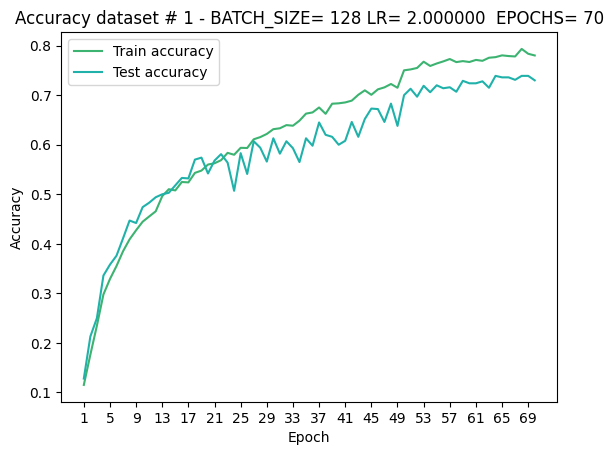

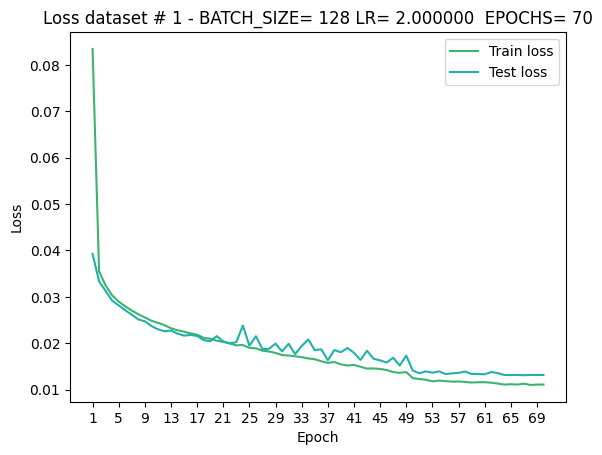

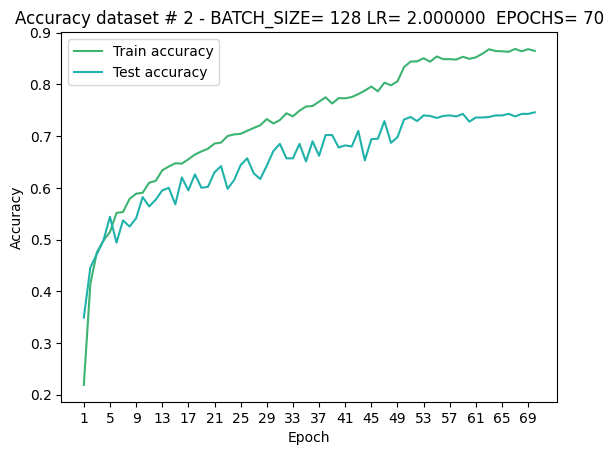

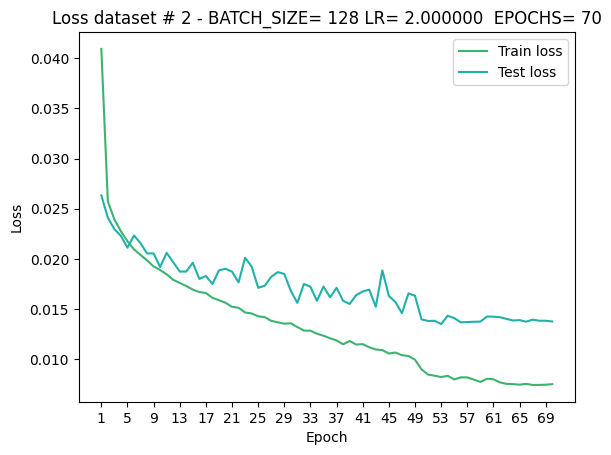

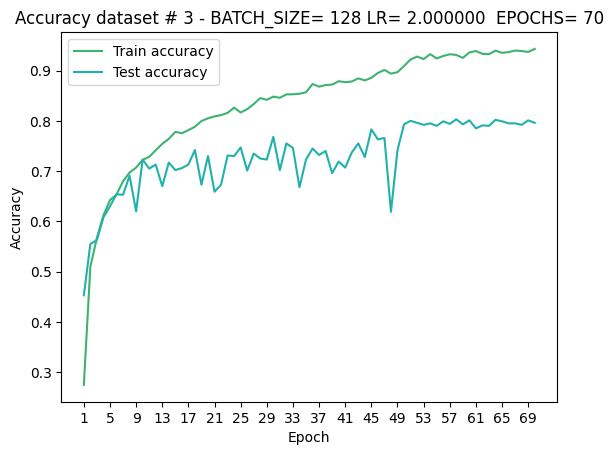

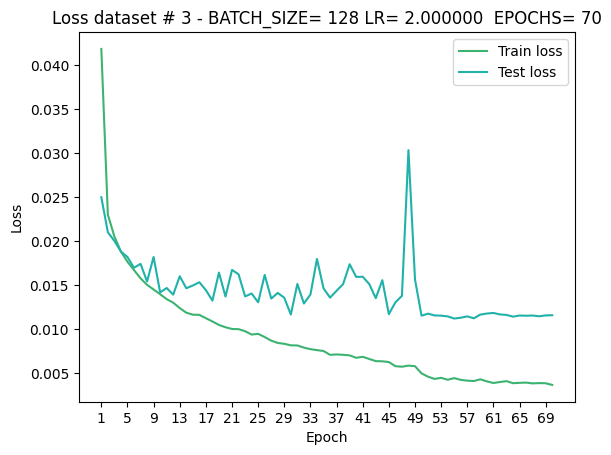

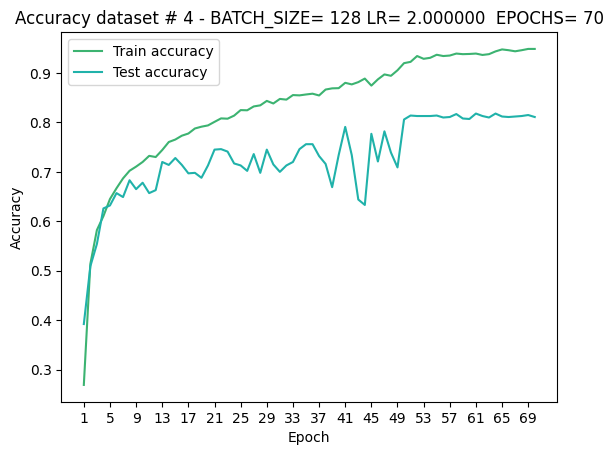

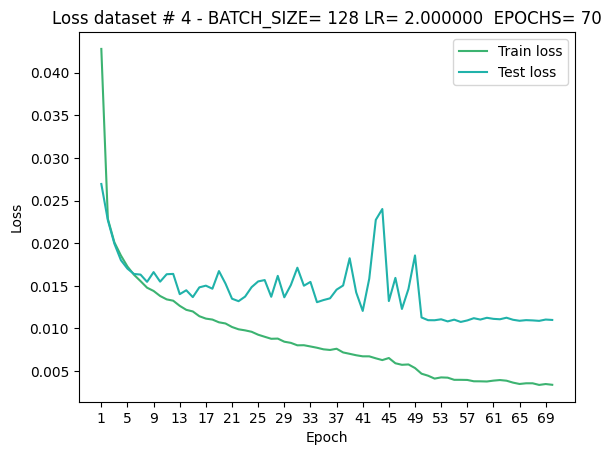

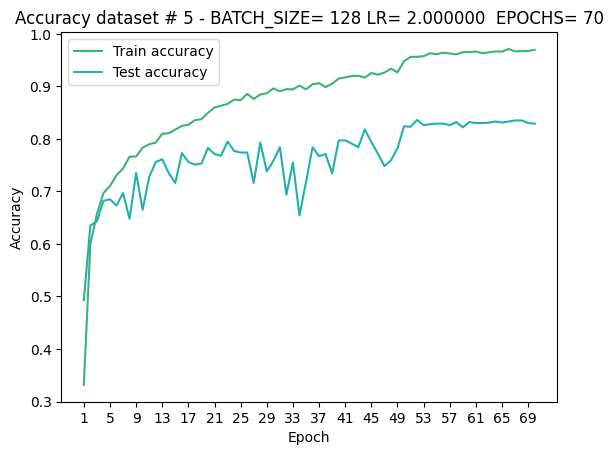

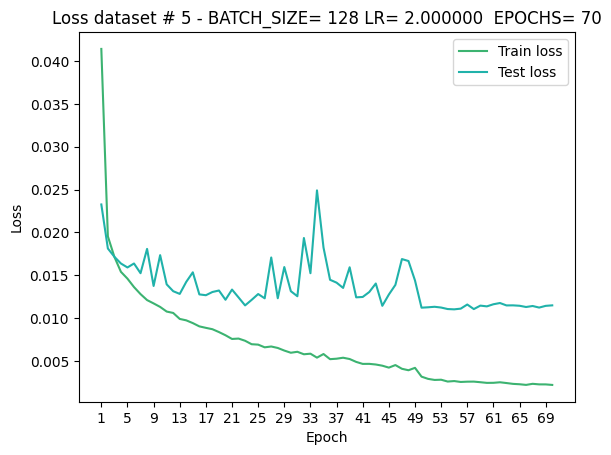

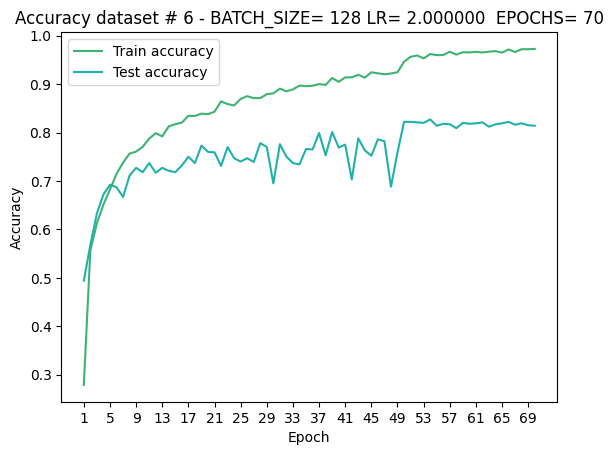

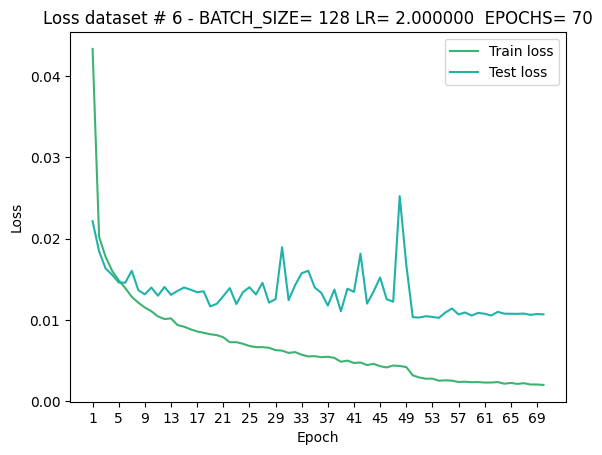

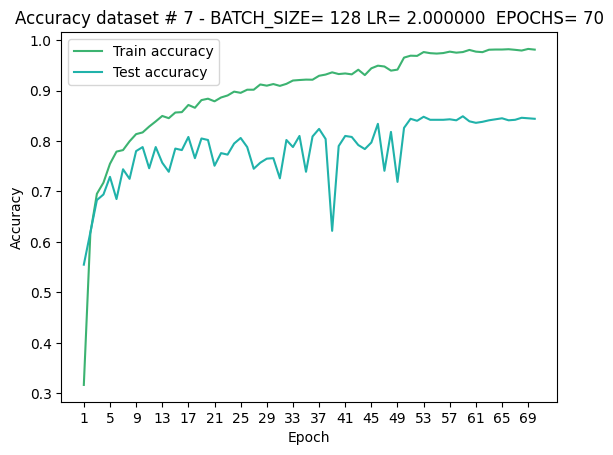

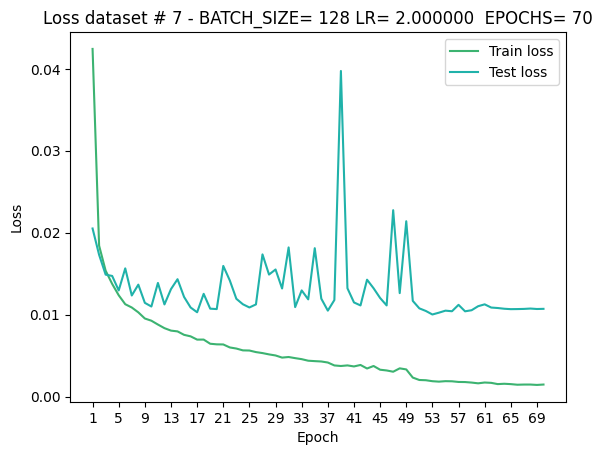

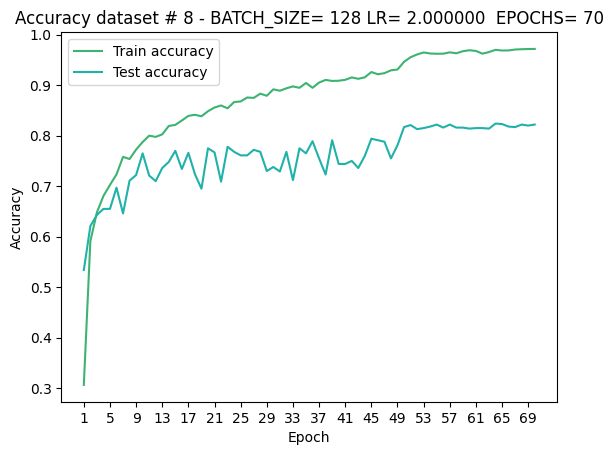

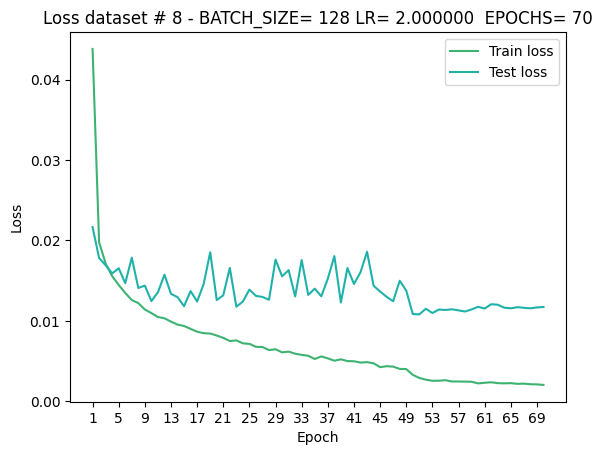

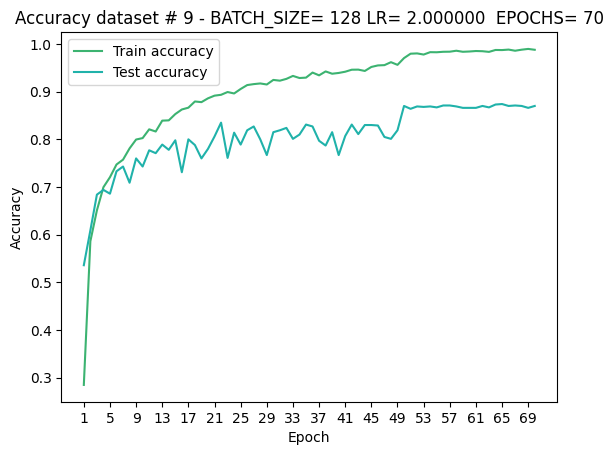

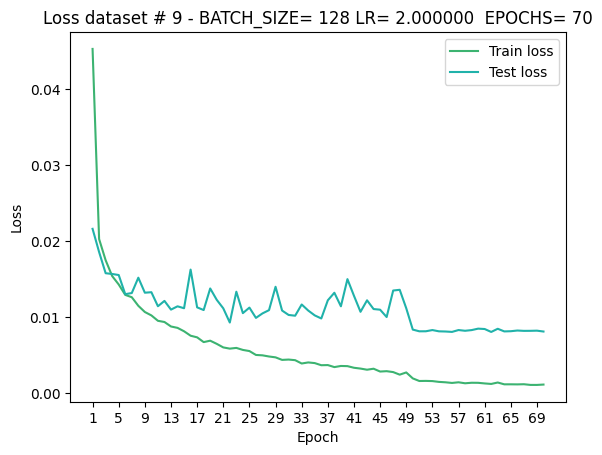

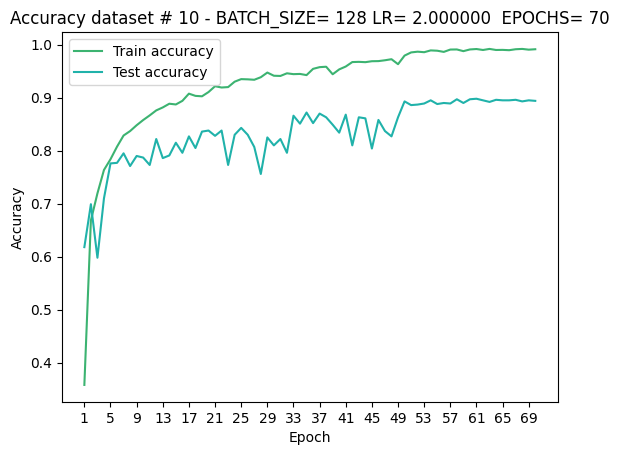

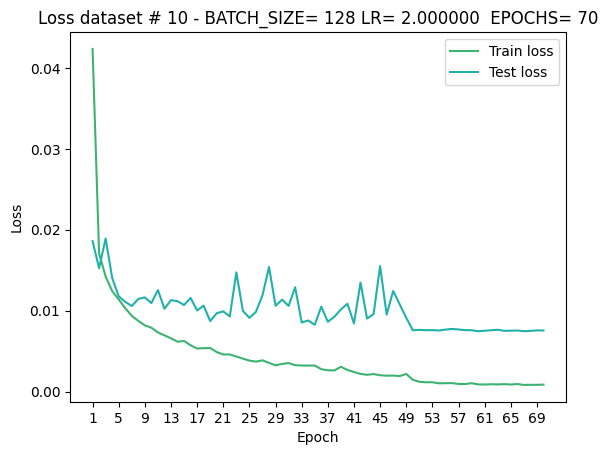

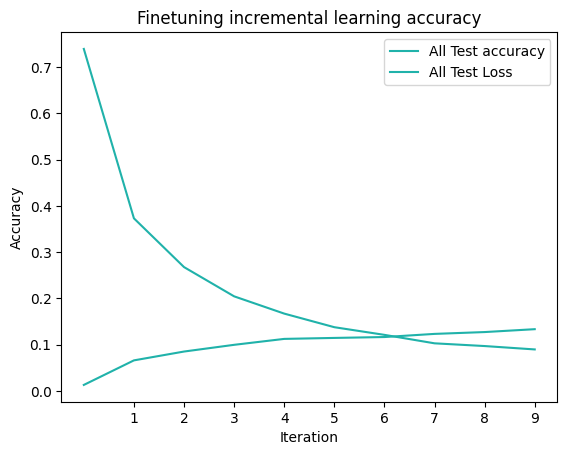

Accuracy last test [0.618, 0.699, 0.598, 0.71, 0.776, 0.777, 0.795, 0.771, 0.79, 0.787, 0.773, 0.822, 0.786, 0.791, 0.815, 0.796, 0.827, 0.805, 0.836, 0.838, 0.828, 0.838, 0.773, 0.83, 0.843, 0.83, 0.807, 0.756, 0.825, 0.81, 0.822, 0.796, 0.866, 0.851, 0.872, 0.852, 0.87, 0.863, 0.849, 0.834, 0.868, 0.81, 0.863, 0.861, 0.804, 0.858, 0.837, 0.827, 0.863, 0.893, 0.886, 0.887, 0.889, 0.895, 0.888, 0.89, 0.889, 0.897, 0.89, 0.897, 0.898, 0.895, 0.892, 0.896, 0.895, 0.895, 0.896, 0.893, 0.895, 0.894]


In [ ]:
plot(new_acc_train_list, new_acc_test_list, new_loss_train_list, new_loss_test_list, all_acc_list, parameters)

## Learning without forgetting

Knowledge distillation loss is a technique used in deep learning to transfer knowledge from a complex or large teacher model to a simpler or smaller student model. 

This is done by introducing an additional loss term, known as the distillation loss, during the training process. 

The distillation loss compares the output predictions of the student model with the softened output probabilities of the teacher model.

Typically, the softmax function is used to convert the raw logits of the teacher model into probabilities.However, instead of using the "hard" probabilities generated by the softmax function, a softened version is used by applying a higher temperature parameter during the softmax operation. This softened probability distribution provides more information about the relative similarities between classes.

The distillation loss is usually computed using a combination of two terms: the cross-entropy loss between the student's predictions and the softened probabilities of the teacher, and an optional term that encourages the student to produce similar internal representations as the teacher, such as intermediate layer activations or attention maps.

In [ ]:
DEVICE = 'cuda'
NUM_CLASSES = 10
BATCH_SIZE = 128
CLASSES_BATCH = 10
STEPDOWN_EPOCHS = [49, 63]
STEPDOWN_FACTOR = 5
LR = 2
MOMENTUM = 0.9
WEIGHT_DECAY = 0.00001
NUM_EPOCHS = 70
LAMBDA = 0.3

In [ ]:
def test(net, test_dataloader, n_classes):
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()

    net.to(DEVICE)
    net.train(False)

    running_loss = 0.0
    running_corrects = 0
    for index, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        labels_hot = torch.eye(n_classes,device = DEVICE)[labels]
        labels_hot = labels_hot.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # loss = criterion(outputs, labels)
        loss = criterion(outputs, labels_hot)

        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate average losses
    epoch_loss = running_loss / float(len(test_dataloader.dataset))
    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataloader.dataset))

    return accuracy, epoch_loss


In [ ]:
# train function
def update_classes(net, n_new_classes):
    in_features = net.fc.in_features
    out_features = net.fc.out_features
    weight = net.fc.weight.data
    
    new_out_features = out_features + n_new_classes

    net.fc = nn.Linear(in_features, new_out_features, bias=False)

    net.fc.weight.data[:out_features] = weight

    return net, new_out_features


In [ ]:
def MultinomialLogisticLoss(old_outputs, new_outputs):#, T):
    # L = -1/N * sum(N) sum(C) softmax(new_outputs) * log(softmax(old_outputs))
    old_outputs = torch.log_softmax(old_outputs, dim=1)
    new_outputs = torch.softmax(new_outputs, dim=1)
    mean = -torch.mean(torch.sum(old_outputs * new_outputs, dim=1), dim=0)

    return mean

### First way

In [ ]:

def train(net, train_dataloader, test_dataloader, n_classes):
    prev_net = copy.deepcopy(net).to(DEVICE)

    criterion = nn.CrossEntropyLoss()
    # criterion = nn.BCEWithLogitsLoss()

    parameters_to_optimize = net.parameters()

    # START
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []
    best_net = []
    best_accuracy = 0

    net.to(DEVICE)

    for epoch in range(NUM_EPOCHS):

        if epoch in STEPDOWN_EPOCHS:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] / STEPDOWN_FACTOR

        running_loss = 0.0
        running_corrects_train = 0

        for index, inputs, labels in train_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            # labels_hot = torch.eye(net.fc.out_features)[labels]
            # labels_hot = labels_hot.to(DEVICE)

            net.train(True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = net(inputs)

            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

            # the first round is a simple CNN (only above loss)
            # we compute the new data on old arc
            # and the new data on new arc
            # compute multinomallogisticloss
            # use above loss (crosentroy on new data as well)

            if n_classes != 10:
                old_outputs = prev_net(inputs)
                new_outputs = outputs[:, :-10]
                old_outputs = old_outputs[:, :-10]
                old_loss = MultinomialLogisticLoss(old_outputs, new_outputs)
                loss = LAMBDA * old_loss + loss

            # loss = criterion(outputs, labels_hot)

            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects_train += torch.sum(preds == labels.data).data.item()

        # Calculate average losses
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        # Calculate accuracy
        epoch_acc = running_corrects_train / float(len(train_dataloader.dataset))
        epoch_test_accuracy, epoch_test_loss = test(net, test_dataloader, n_classes)

        if epoch % 10 == 0 or epoch == (NUM_EPOCHS - 1):
            print('Epoch {} train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch, epoch_loss, epoch_acc))
            print('Epoch {} test Loss:{:.4f} test Accuracy:{:.4f}'.format(epoch, epoch_test_loss, epoch_test_accuracy))

            for param_group in optimizer.param_groups:
                print('Learning rate:{}'.format(param_group['lr']))
            print('-' * 30)

        epoch_test_accuracy, epoch_test_loss = test(net, test_dataloader, n_classes)

        train_accuracies.append(epoch_acc)
        train_losses.append(epoch_loss)
        test_accuracies.append(epoch_test_accuracy)
        test_losses.append(epoch_test_loss)

        if epoch_test_accuracy > best_accuracy:
            best_accuracy = epoch_test_accuracy
            best_net = copy.deepcopy(net)

    return best_net, train_accuracies, train_losses, test_accuracies, test_losses

In [ ]:
def incremental_learning():
    # Define transforms for training phase
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    net = resnet32(num_classes=NUM_CLASSES)
    n_classes = NUM_CLASSES

    new_acc_train_list = []
    new_loss_train_list = []
    new_acc_test_list = []
    new_loss_test_list = []
    all_acc_list = []

    for i in range(CLASSES_BATCH):
        print('-' * 30)
        print(f'**** ITERATION {i + 1} ****')
        print('-' * 30)

        print('Loading the Datasets ...')
        print('-' * 30)

        train_dataset = Cifar100(classes=range(i * 10, (i + 1) * 10), train=True, transform=transform_train)
        test_dataset = Cifar100(classes=range(i * 10, (i + 1) * 10), train=False, transform=transform_test)

        print('-' * 30)
        print('Training ...')
        print('-' * 30)

        # Prepare Dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

        net, train_accuracies, train_losses, test_accuracies, test_losses = train(net, train_dataloader, test_dataloader, n_classes)

        new_acc_train_list.append(train_accuracies)
        new_loss_train_list.append(train_losses)
        new_acc_test_list.append(test_accuracies)
        new_loss_test_list.append(test_losses)

        print('Testing ...')
        print('-' * 30)


        all_classes_dataset = Cifar100(classes=range(0, (i + 1) * 10), train=False, transform=transform_test)

        # Prepare Dataloader
        test_all_dataloader = DataLoader(all_classes_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

        print('All classes')


        all_result = test(net, test_all_dataloader,n_classes)
        print(f'In First {(i+1)*10} class model Accuracy: {all_result[0]}, loss: {all_result[1]}')
        all_acc_list.append(all_result)

        print('-'*30)

        net, n_classes = update_classes(net, 10)
        print('n_classes', n_classes)

        print('-' * 30)

    return new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list

In [ ]:
new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list = incremental_learning()

------------------------------
**** ITERATION 1 ****
------------------------------
Loading the Datasets ...
------------------------------
Files already downloaded and verified
Files already downloaded and verified
------------------------------
Training ...
------------------------------
Epoch 0 train Loss:2.9520 Accuracy:0.1180
Epoch 0 test Loss:0.7151 test Accuracy:0.1460
Learning rate:2
------------------------------
Epoch 10 train Loss:1.9346 Accuracy:0.2980
Epoch 10 test Loss:0.8032 test Accuracy:0.3060
Learning rate:2
------------------------------
Epoch 20 train Loss:1.5120 Accuracy:0.4800
Epoch 20 test Loss:0.8301 test Accuracy:0.4410
Learning rate:2
------------------------------
Epoch 30 train Loss:1.1112 Accuracy:0.6204
Epoch 30 test Loss:0.8976 test Accuracy:0.5740
Learning rate:2
------------------------------
Epoch 40 train Loss:0.7754 Accuracy:0.7360
Epoch 40 test Loss:1.0729 test Accuracy:0.5910
Learning rate:2
------------------------------
Epoch 50 train Loss:0.3889

In [ ]:
NUM_CLASSES = 100
BATCH_SIZE = 512

In [ ]:
parameters = {
    'name': 'Learning without Forgetting',
    'NUM_CLASSES': NUM_CLASSES,
    'BATCH_SIZE' : BATCH_SIZE,
    'CLASSES_BATCH' : CLASSES_BATCH,
    'STEPDOWN_EPOCHS' : STEPDOWN_EPOCHS,
    'STEPDOWN_FACTOR' : STEPDOWN_FACTOR,
    'LR' : LR,
    'MOMENTUM' : MOMENTUM,
    'WEIGHT_DECAY' : WEIGHT_DECAY,
    'NUM_EPOCHS' : NUM_EPOCHS
}

In [ ]:
def plot(new_acc_train, new_acc_test, new_loss_train, new_loss_test, all_acc, args):
    num_epochs = len(new_acc_train[0])
    x = np.linspace(1, num_epochs, num_epochs)

    for i, (acc_train, acc_test, loss_train, loss_test) in enumerate(zip(new_acc_train, new_acc_test, new_loss_train, new_loss_test)):

        title = 'Accuracy dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d' \
                % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])
        title2 = 'Loss dataset # %d - BATCH_SIZE= %d LR= %f  EPOCHS= %d' \
                 % (i + 1, args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])

        plt.plot(x, acc_train, color='mediumseagreen')
        plt.plot(x, acc_test, color='lightseagreen')
        plt.title(title)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend(['Train accuracy', 'Test accuracy'], loc='best')
        plt.show()

        plt.plot(x, loss_train, color='mediumseagreen')
        plt.plot(x, loss_test, color='lightseagreen')
        plt.title(title2)
        plt.xticks(np.arange(1, num_epochs, 4))
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(['Train loss', 'Test loss'], loc='best')
        plt.show()

    plt.plot(all_acc, color='lightseagreen')
    plt.title('%s incremental learning accuracy' % (args['name']))
    plt.xticks(np.arange(1, len(all_acc), 1))
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend(['Test accuracy','Test Loss'], loc='best')
    plt.show()

    # csv_name = '%s - BATCH_SIZE= %d LR= %f  EPOCHS= %d' % (args['name'], args['BATCH_SIZE'], args['LR'], args['NUM_EPOCHS'])
    # pd.DataFrame(all_acc).to_csv('./Results/%s.csv' % csv_name)

    print('Accuracy last test', new_acc_test[-1])


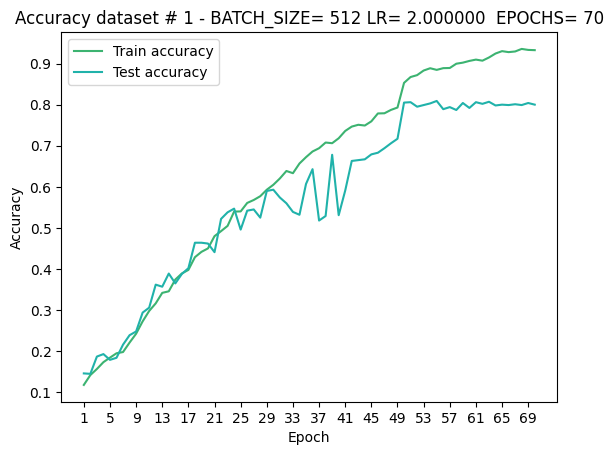

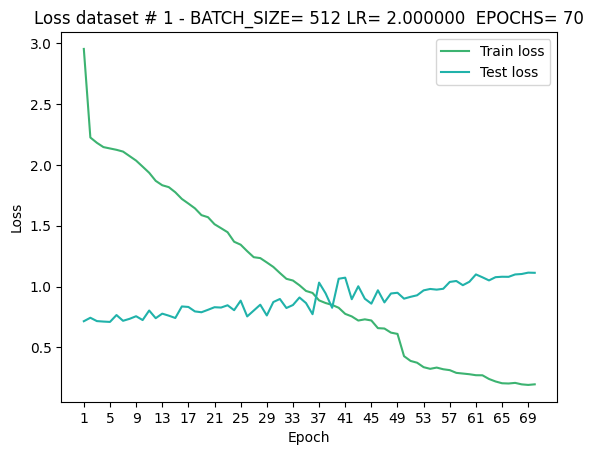

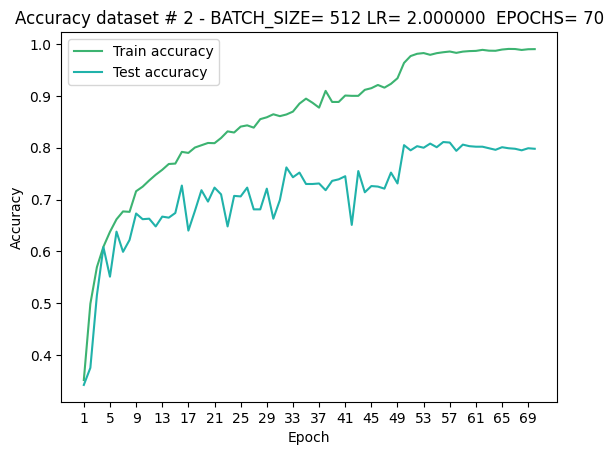

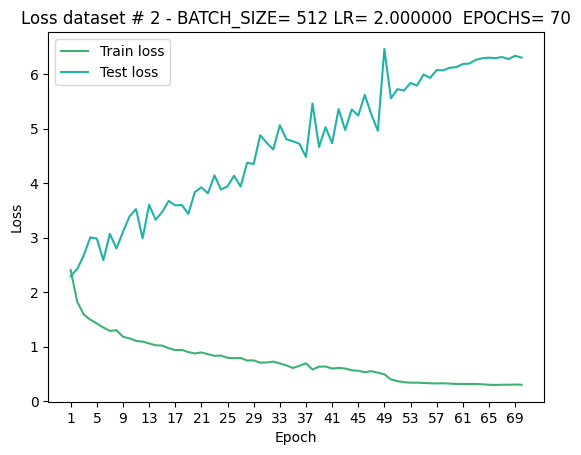

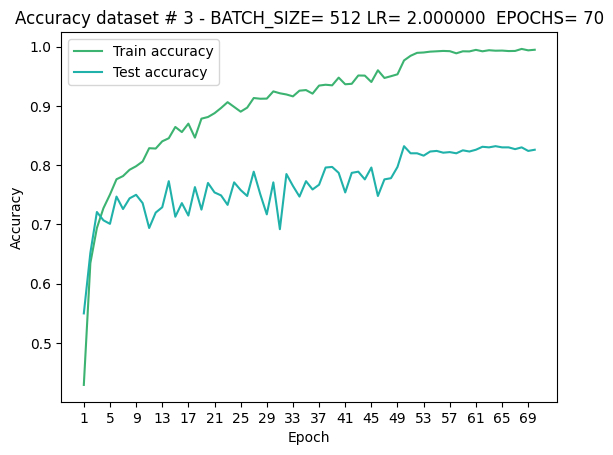

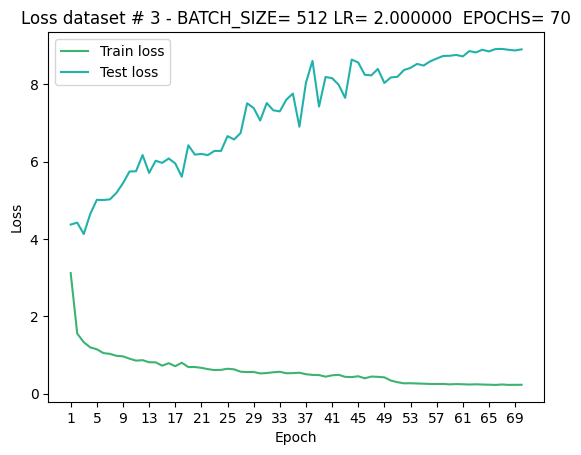

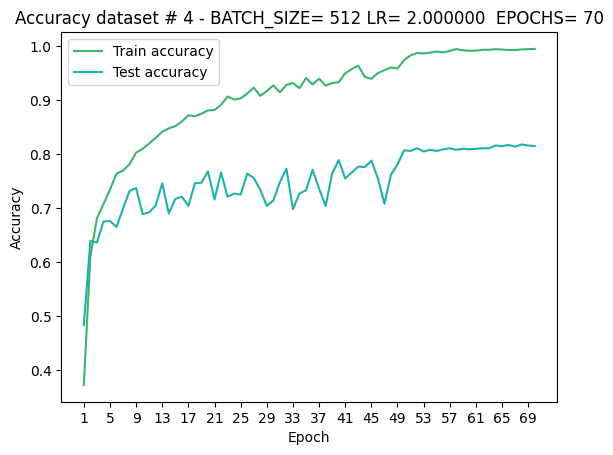

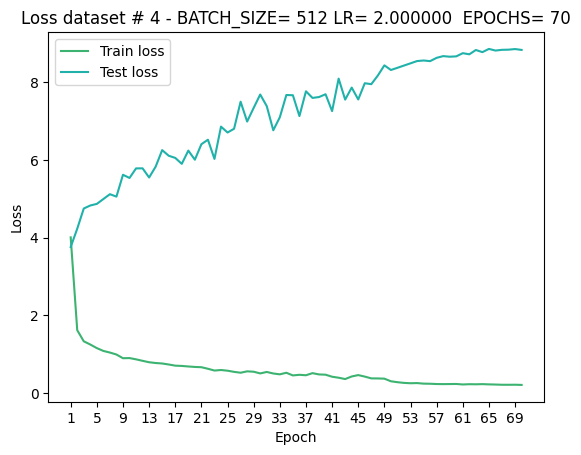

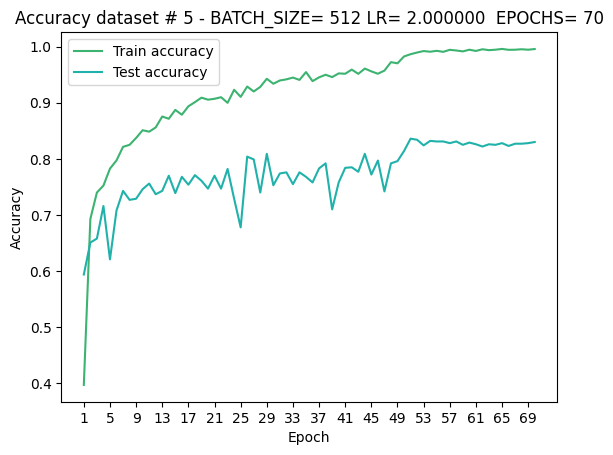

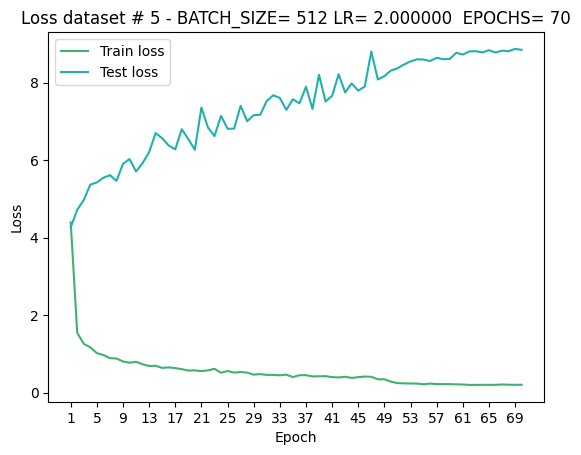

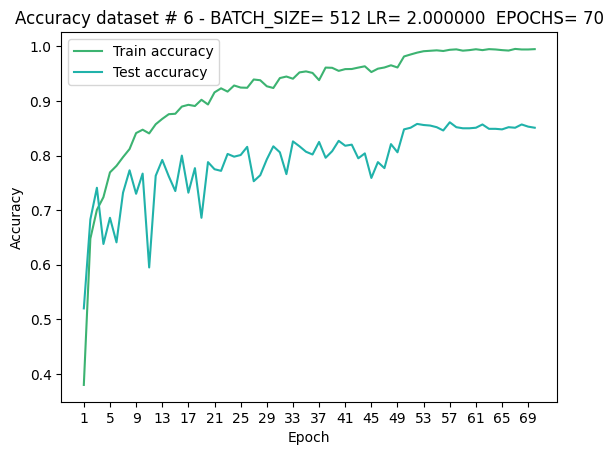

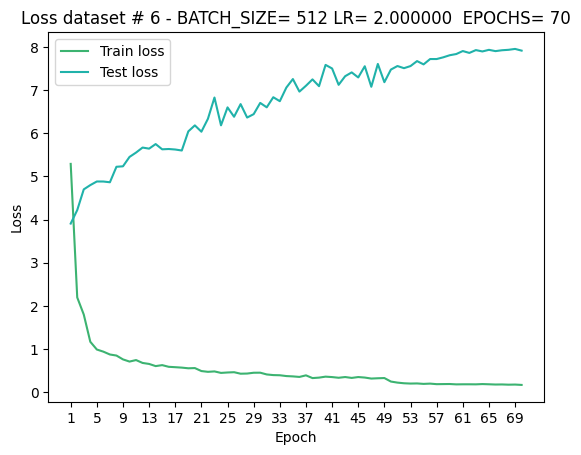

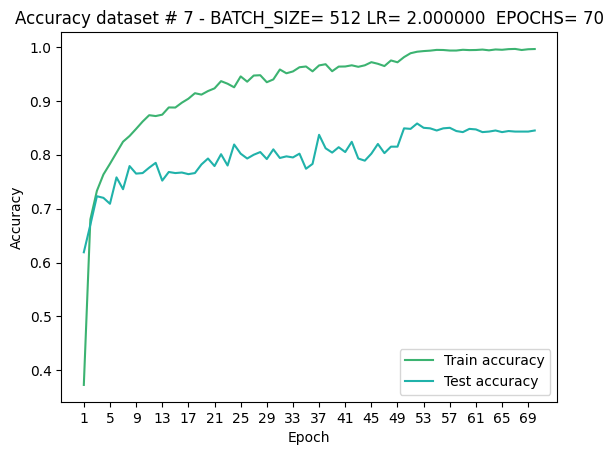

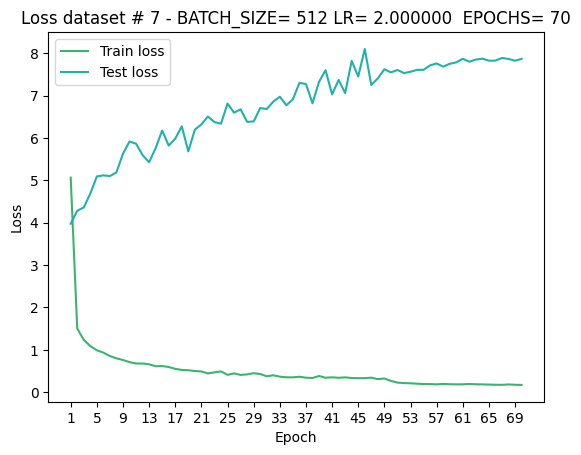

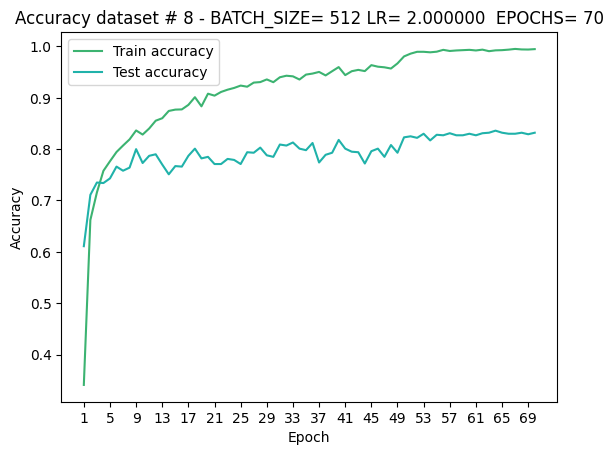

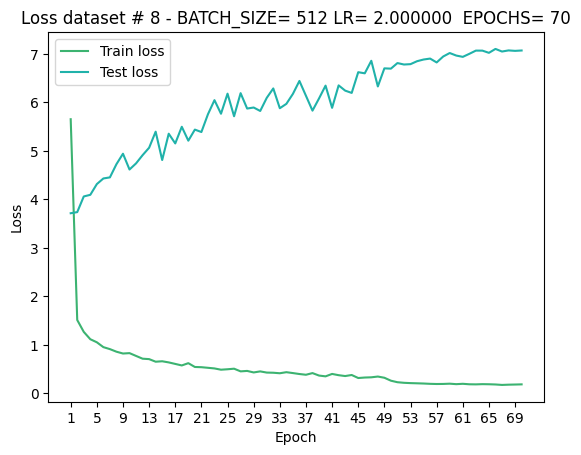

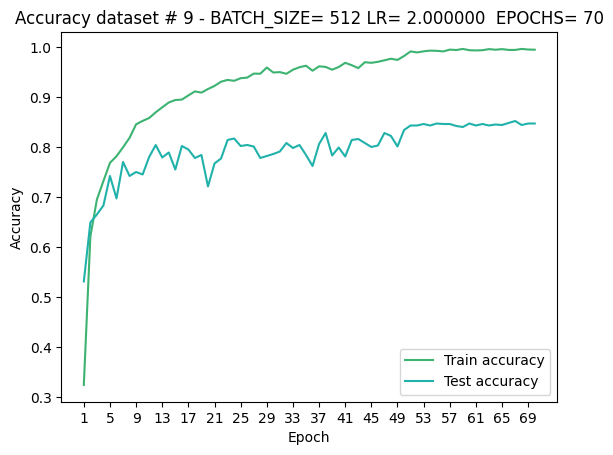

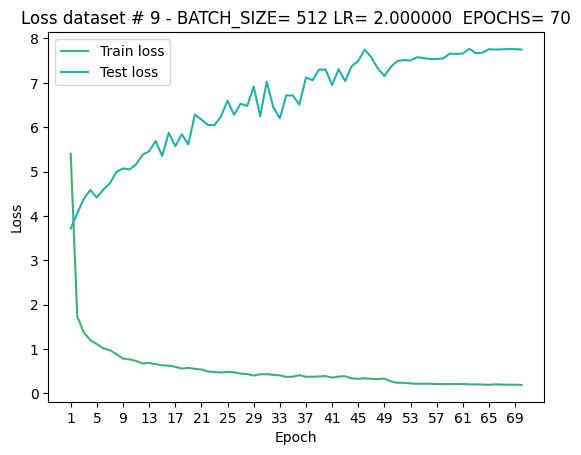

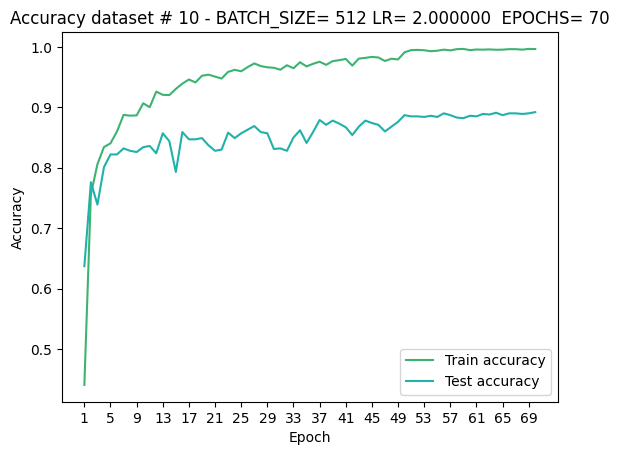

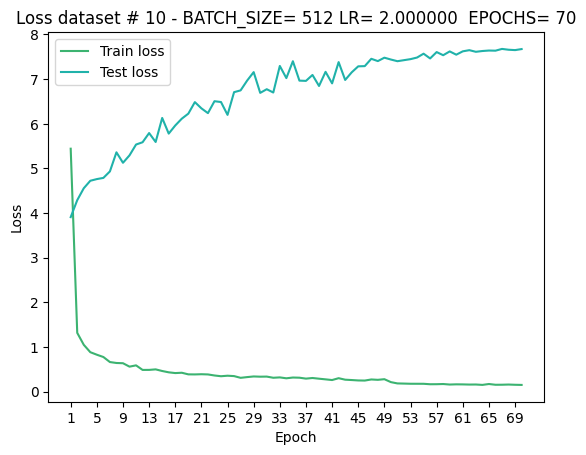

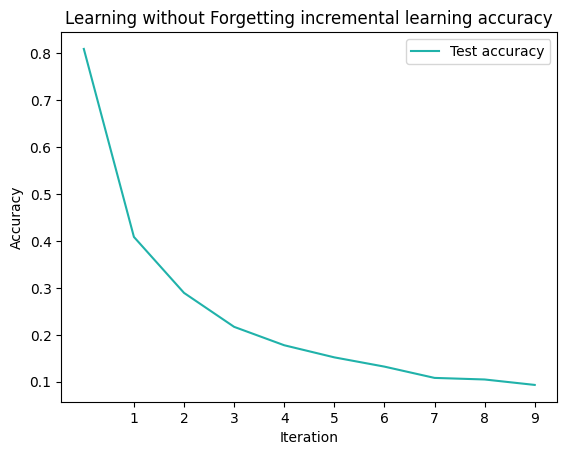

Accuracy last test [0.637, 0.776, 0.739, 0.801, 0.822, 0.822, 0.832, 0.828, 0.826, 0.834, 0.836, 0.824, 0.857, 0.844, 0.793, 0.859, 0.847, 0.847, 0.849, 0.837, 0.828, 0.83, 0.858, 0.849, 0.857, 0.863, 0.869, 0.859, 0.857, 0.831, 0.832, 0.828, 0.85, 0.862, 0.841, 0.859, 0.879, 0.871, 0.878, 0.873, 0.867, 0.854, 0.868, 0.878, 0.874, 0.871, 0.86, 0.868, 0.876, 0.887, 0.885, 0.885, 0.884, 0.886, 0.884, 0.89, 0.887, 0.883, 0.882, 0.886, 0.885, 0.889, 0.888, 0.891, 0.887, 0.89, 0.89, 0.889, 0.89, 0.892]


In [ ]:
import numpy as np
plot(new_acc_train_list, new_acc_test_list, new_loss_train_list, new_loss_test_list, np.asarray(all_acc_list)[:, 0], parameters)

### Second way

In [ ]:
# train function
def update_classes(net, n_new_classes):
    in_features = net.fc.in_features
    out_features = net.fc.out_features
    weight = net.fc.weight.data
    
    new_out_features = out_features + n_new_classes

    net.fc = nn.Linear(in_features, new_out_features, bias=False)

    net.fc.weight.data[:out_features] = weight

    return net, new_out_features


In [ ]:
def MultinomialLogisticLoss(old_outputs, new_outputs):#, T):
    # L = -1/N * sum(N) sum(C) softmax(new_outputs) * log(softmax(old_outputs))
    old_outputs = torch.log_softmax(old_outputs, dim=1)
    new_outputs = torch.softmax(new_outputs, dim=1)
    mean = -torch.mean(torch.sum(old_outputs * new_outputs, dim=1), dim=0)

    return mean

In [ ]:
def test(net, test_dataloader, n_classes):
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()

    net.to(DEVICE)
    net.train(False)

    running_loss = 0.0
    running_corrects = 0
    for index, images, labels in test_dataloader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)

        labels_hot = torch.eye(n_classes,device = DEVICE)[labels]
        labels_hot = labels_hot.to(DEVICE)

        # Forward Pass
        outputs = net(images)

        # Get predictions
        _, preds = torch.max(outputs.data, 1)

        # loss = criterion(outputs, labels)
        loss = criterion(outputs, labels_hot)

        # statistics
        running_loss += loss.item() * images.size(0)
        running_corrects += torch.sum(preds == labels.data).data.item()

    # Calculate average losses
    epoch_loss = running_loss / float(len(test_dataloader.dataset))
    # Calculate Accuracy
    accuracy = running_corrects / float(len(test_dataloader.dataset))

    return accuracy, epoch_loss


In [ ]:
def incremental_learning():
    # Define transforms for training phase
    transform_train = transforms.Compose([
        transforms.RandomCrop(32, padding=4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    net = resnet32(num_classes=NUM_CLASSES)

    n_classes = NUM_CLASSES

    new_acc_train_list = []
    new_loss_train_list = []
    new_acc_test_list = []
    new_loss_test_list = []
    all_acc_list = []

    for i in range(CLASSES_BATCH):
        print('-' * 30)
        print(f'**** ITERATION {i + 1} ****')
        print('-' * 30)

        print('Loading the Datasets ...')
        print('-' * 30)

        train_dataset = Cifar100(classes=range(i * 10, (i + 1) * 10), train=True, transform=transform_train)
        test_dataset = Cifar100(classes=range(i * 10, (i + 1) * 10), train=False, transform=transform_test)

        print('-' * 30)
        print('Training ...')
        print('-' * 30)

        # Prepare Dataloaders
        train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=4)
        test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)


        net, train_accuracies, train_losses, test_accuracies, test_losses = train(net, train_dataloader, test_dataloader, n_classes)

        new_acc_train_list.append(train_accuracies)
        new_loss_train_list.append(train_losses)
        new_acc_test_list.append(test_accuracies)
        new_loss_test_list.append(test_losses)

        print('Testing ...')
        print('-' * 30)

        previous_classes = np.array([])


        all_classes_dataset = Cifar100(classes=range(0, (i + 1) * 10), train=False, transform=transform_test)

        # Prepare Dataloader
        test_all_dataloader = DataLoader(all_classes_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=4)

        print('All classes')


        all_result = test(net, test_all_dataloader,n_classes)
        print(f'In First {(i+1)*10} class model Accuracy: {all_result[0]}, loss: {all_result[1]}')
        all_acc_list.append(all_result)

        print('-'*30)

        net, n_classes = update_classes(net, 10)
        print('n_classes', n_classes)

        print('-' * 30)

    return new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list

In [ ]:

def train(net, train_dataloader, test_dataloader, n_classes):
    prev_net = copy.deepcopy(net).to(DEVICE)

    # criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()

    parameters_to_optimize = net.parameters()

    # START
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, weight_decay=WEIGHT_DECAY)

    train_accuracies = []
    train_losses = []
    test_accuracies = []
    test_losses = []
    best_net = []
    best_accuracy = 0

    net.to(DEVICE)

    for epoch in range(NUM_EPOCHS):

        if epoch in STEPDOWN_EPOCHS:
            for param_group in optimizer.param_groups:
                param_group['lr'] = param_group['lr'] / STEPDOWN_FACTOR

        running_loss = 0.0
        running_corrects_train = 0

        for index, inputs, labels in train_dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            labels_hot = torch.eye(net.fc.out_features, device=DEVICE)[labels]
            labels_hot = labels_hot.to(DEVICE)

            net.train(True)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward
            outputs = net(inputs)
      

            _, preds = torch.max(outputs, 1)

            # loss = criterion(outputs, labels)

            if n_classes != 10:
              with torch.no_grad():
                old_outputs = torch.sigmoid(prev_net(inputs)).to(DEVICE)
                labels_hot = torch.cat((old_outputs[:, :-10], labels_hot[:, -10:]), 1)


            loss = criterion(outputs, labels_hot)
  
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects_train += torch.sum(preds == labels.data).data.item()

        # Calculate average losses
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        # Calculate accuracy
        epoch_acc = running_corrects_train / float(len(train_dataloader.dataset))
        epoch_test_accuracy, epoch_test_loss = test(net, test_dataloader, n_classes)

        if epoch % 10 == 0 or epoch == (NUM_EPOCHS - 1):
            print('Epoch {} train Loss:{:.4f} Accuracy:{:.4f}'.format(epoch, epoch_loss, epoch_acc))
            print('Epoch {} test Loss:{:.4f} test Accuracy:{:.4f}'.format(epoch, epoch_test_loss, epoch_test_accuracy))

            for param_group in optimizer.param_groups:
                print('Learning rate:{}'.format(param_group['lr']))
            print('-' * 30)

        epoch_test_accuracy, epoch_test_loss = test(net, test_dataloader, n_classes)

        train_accuracies.append(epoch_acc)
        train_losses.append(epoch_loss)
        test_accuracies.append(epoch_test_accuracy)
        test_losses.append(epoch_test_loss)

        if epoch_test_accuracy > best_accuracy:
            best_accuracy = epoch_test_accuracy
            best_net = copy.deepcopy(net)

    return best_net, train_accuracies, train_losses, test_accuracies, test_losses

In [ ]:
new_acc_train_list, new_loss_train_list, new_acc_test_list, new_loss_test_list, all_acc_list = incremental_learning()

------------------------------
**** ITERATION 1 ****
------------------------------
Loading the Datasets ...
------------------------------
Files already downloaded and verified
Files already downloaded and verified
------------------------------
Training ...
------------------------------
Epoch 0 train Loss:0.3595 Accuracy:0.1788
Epoch 0 test Loss:0.3009 test Accuracy:0.2620
Learning rate:2
------------------------------
Epoch 10 train Loss:0.1898 Accuracy:0.5852
Epoch 10 test Loss:0.2569 test Accuracy:0.4930
Learning rate:2
------------------------------
Epoch 20 train Loss:0.1195 Accuracy:0.7564
Epoch 20 test Loss:0.1306 test Accuracy:0.7340
Learning rate:2
------------------------------
Epoch 30 train Loss:0.0843 Accuracy:0.8344
Epoch 30 test Loss:0.1561 test Accuracy:0.7150
Learning rate:2
------------------------------
Epoch 40 train Loss:0.0612 Accuracy:0.8820
Epoch 40 test Loss:0.1962 test Accuracy:0.7120
Learning rate:2
------------------------------
Epoch 50 train Loss:0.0284

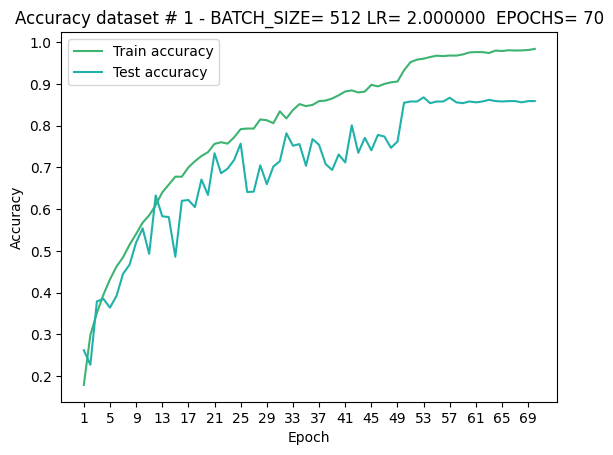

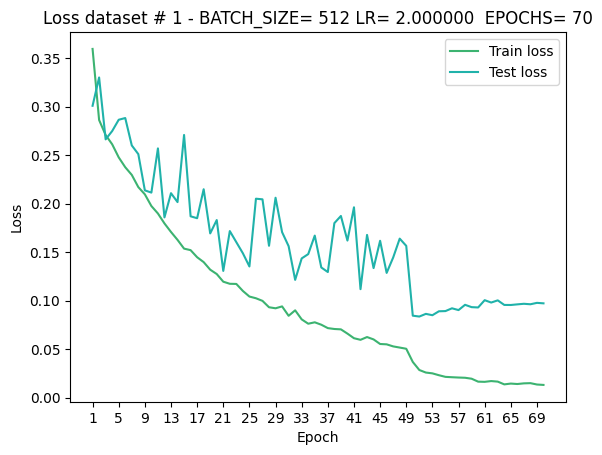

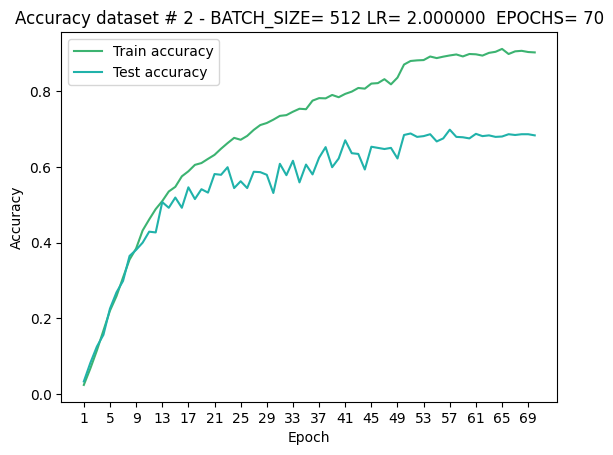

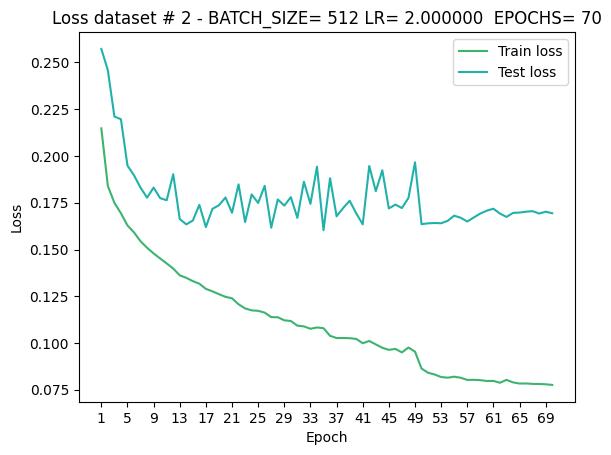

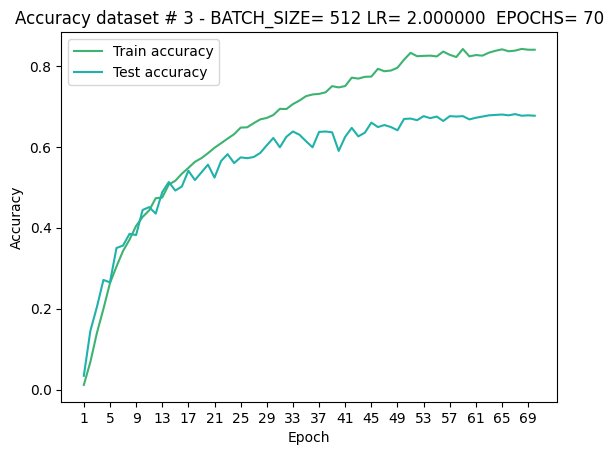

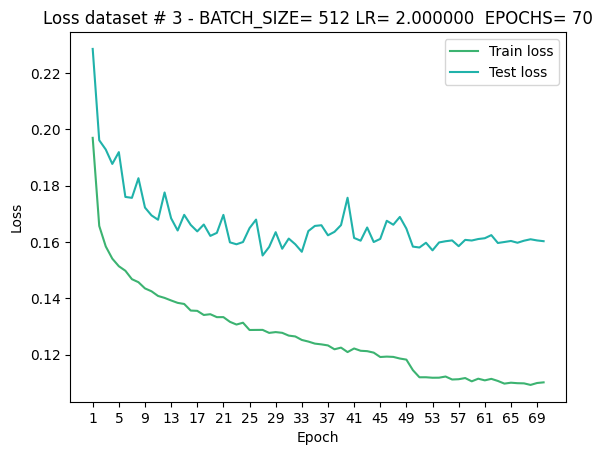

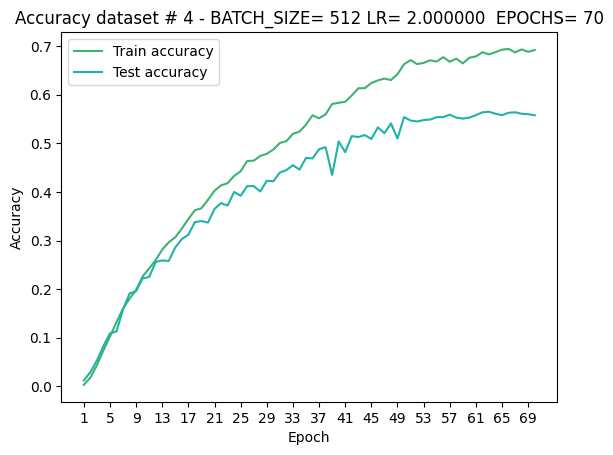

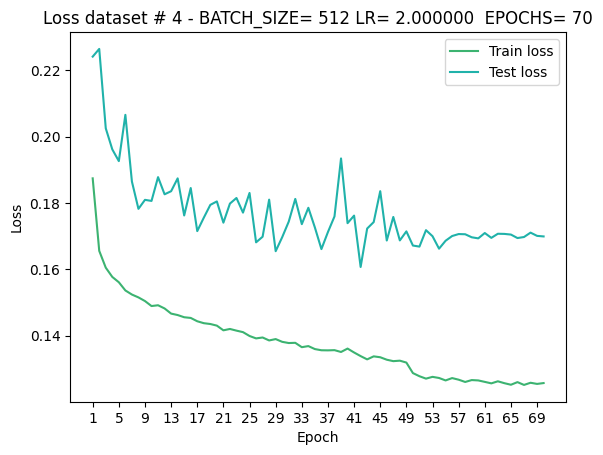

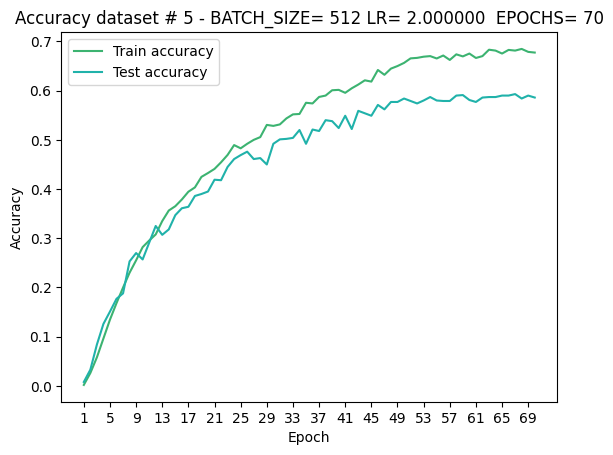

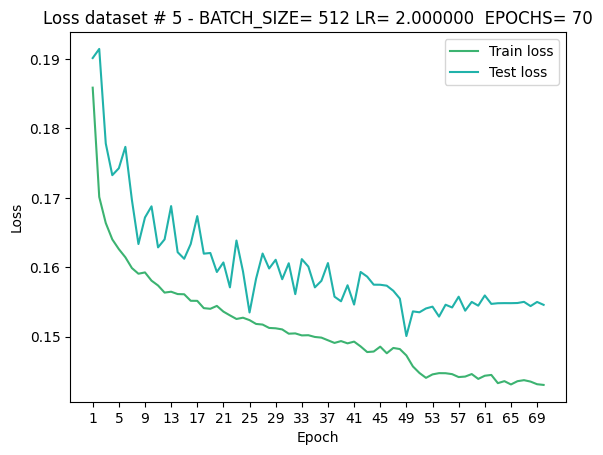

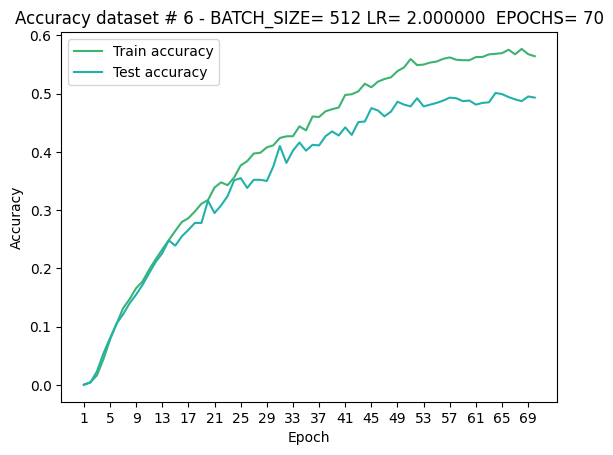

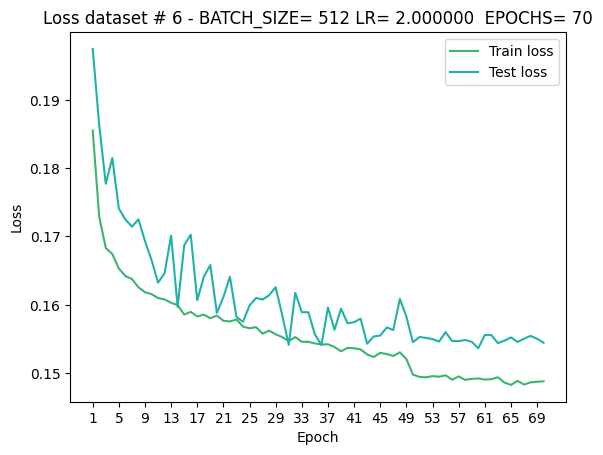

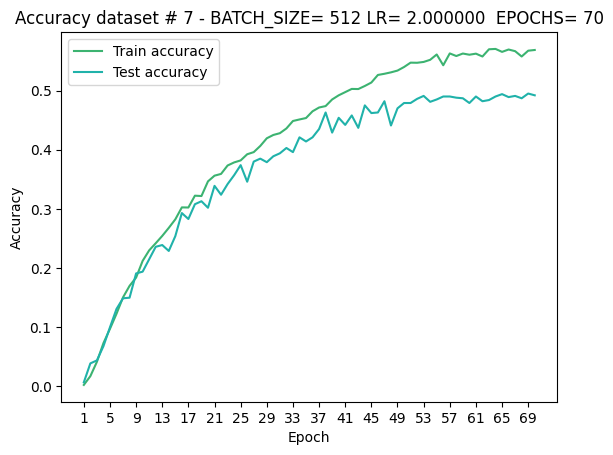

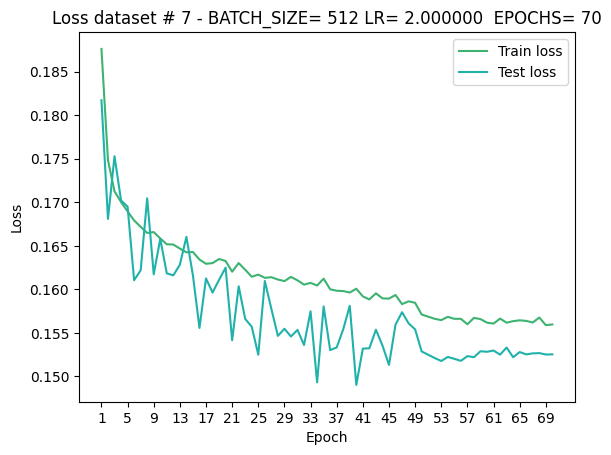

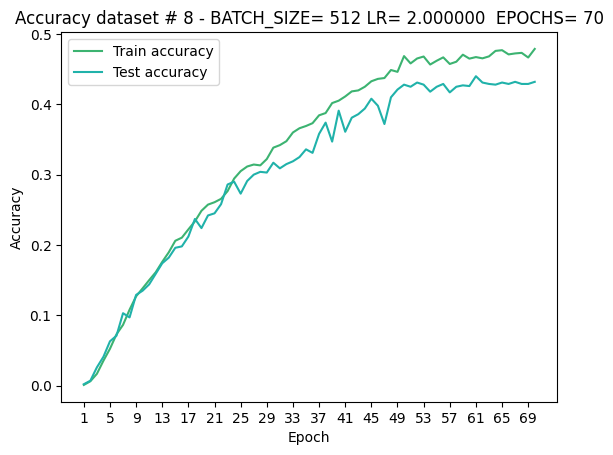

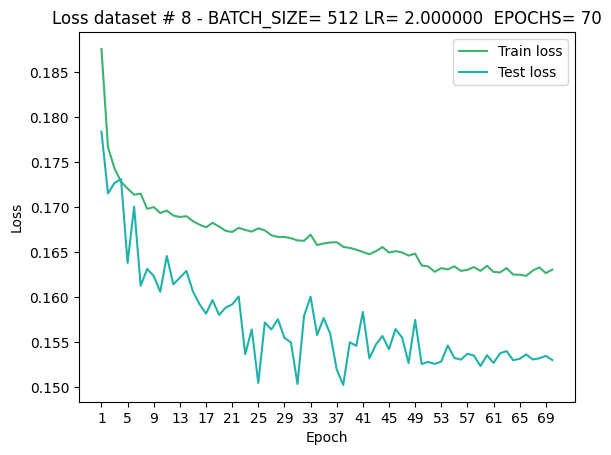

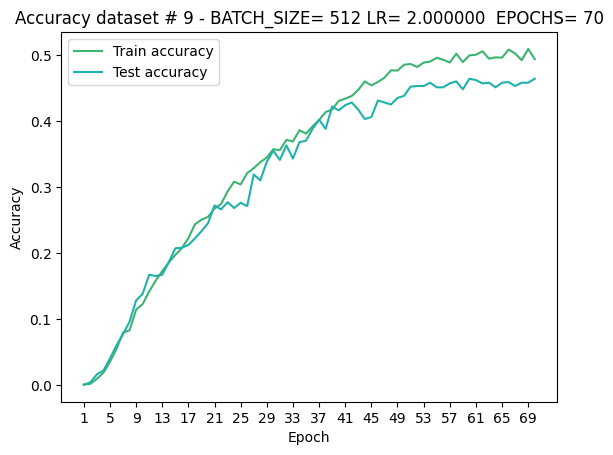

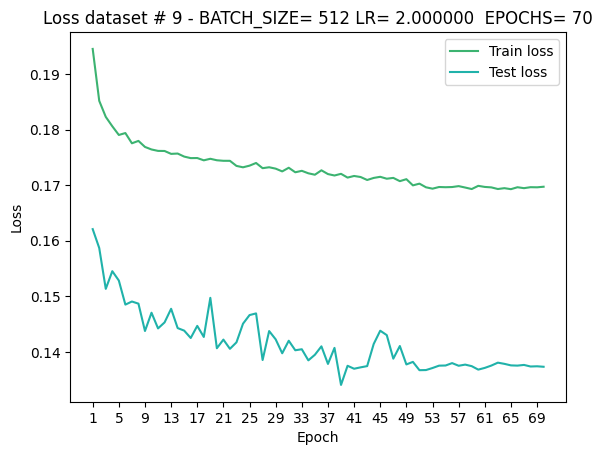

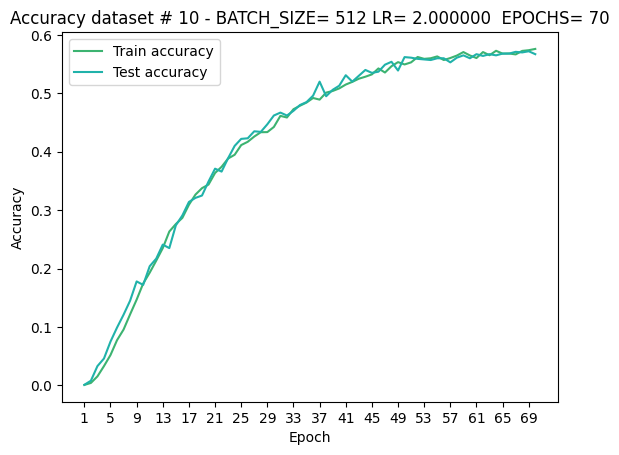

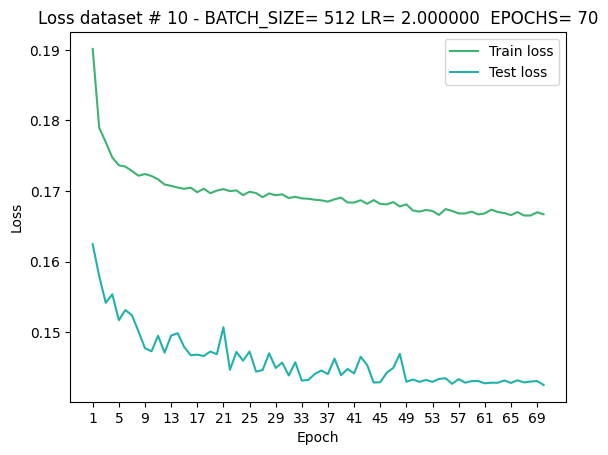

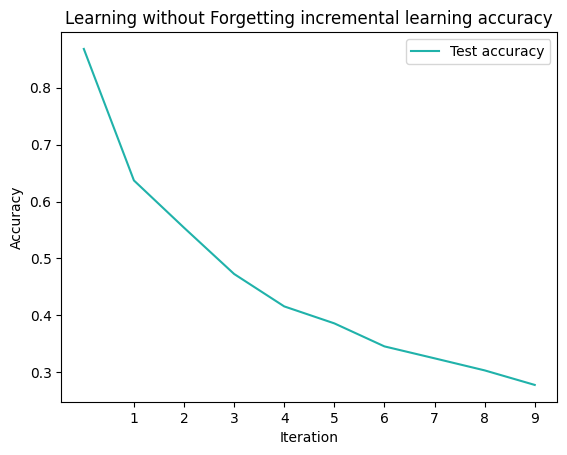

Accuracy last test [0.001, 0.008, 0.033, 0.046, 0.075, 0.099, 0.121, 0.145, 0.178, 0.172, 0.204, 0.217, 0.241, 0.235, 0.274, 0.291, 0.314, 0.321, 0.325, 0.349, 0.371, 0.366, 0.389, 0.41, 0.422, 0.423, 0.435, 0.434, 0.447, 0.462, 0.467, 0.462, 0.47, 0.48, 0.485, 0.496, 0.52, 0.495, 0.506, 0.513, 0.531, 0.52, 0.53, 0.54, 0.535, 0.537, 0.549, 0.554, 0.539, 0.562, 0.561, 0.559, 0.558, 0.557, 0.56, 0.56, 0.553, 0.561, 0.565, 0.56, 0.567, 0.564, 0.567, 0.565, 0.568, 0.568, 0.571, 0.57, 0.572, 0.567]


In [ ]:
plot(new_acc_train_list, new_acc_test_list, new_loss_train_list, new_loss_test_list, np.asarray(all_acc_list)[:, 0], parameters)

## iCaRL

iCaRL maintains a set of exemplar images. These exemplars are selected from the training images of the new class and are used to represent the class.

In [12]:
import numpy as np
import time
import random 
from copy import deepcopy
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.nn import BCEWithLogitsLoss
from torchvision import transforms

In [11]:
parameters = {
    'NUM_CLASSES': 100,
    'BATCH_SIZE' : 128,
    'CLASSES_BATCH' : 10,
    'STEPDOWN_EPOCHS' : [49, 63],
    'STEPDOWN_FACTOR' : 5,
    'LR' : 2,
    'MOMENTUM' : 0.9,
    'WEIGHT_DECAY' : 0.00001,
    'NUM_EPOCHS' : 70
}

In [13]:
class iCaRL():
    
    def __init__(self, memory=2000, params=None):
        self.memory = memory
        self.params = params
        self.device = 'cuda'
        
    def different_classifier(self, data, exemplars, net, classifier):
      
      print('-'*30)
      print(f'**** Classification: Different classifier ****')
      print('-'*30)
      
      train_data = []
      targets = []

      print(f'**** fitting the classifier on the exemplars... ****')
      print('-'*30)
      for key in exemplars:

        loader = DataLoader(exemplars[key], batch_size=1024, shuffle=False, num_workers=4, drop_last=False)
        mean = torch.zeros((1,64),device=self.device)

        for _, images, labels in loader:
          with torch.no_grad():

            images = images.to(self.device)
            outputs = net(images,features=True)
            
            for output,label in zip(outputs,labels):
              train_data.append(np.array(output.cpu()))
              targets.append(np.array(label))
    
      classifier.fit(train_data, targets)

      loader = DataLoader(data, batch_size=1024, shuffle=False, num_workers=4, drop_last=False)

      running_correct = 0.0
      print(f'**** predicting... ****')
      print('-'*30)

      for _, images, labels in loader:
        
        images = images.to(self.device)
        
        with torch.no_grad():

          outputs = net(images,features=True)
          preds = []

          for output in outputs:

            pred = classifier.predict([np.array(output.cpu())])
            preds.append(pred)
          
          for label, pred in zip(labels, preds):
            if label == pred[0]:
              running_correct += 1
      
      accuracy = running_correct/len(data)
      print('Accuracy:{:.4f}'.format(accuracy))

      return accuracy    

    def NME(self, data, exemplars, net, n_classes):
      print('-'*30)
      print(f'**** Classification: NME ****')
      print('-'*30)
      
      means = dict.fromkeys(np.arange(n_classes))
      net.eval()

      # compute exemplars prototypes
      print(f'**** computing means of exemplars... ****')
      print('-'*30)
      for key in exemplars:
        
        loader = DataLoader(exemplars[key], batch_size=1024, shuffle=False, num_workers=4, drop_last=False)
        mean = torch.zeros((1,64), device=self.device)
        
        for _, images, _ in loader:
          with torch.no_grad():

            images = images.to(self.device)
            outputs = net(images, features=True)
            
            for output in outputs:
              mean += output
        
        mean = mean / len(exemplars[key])
        means[key] = mean / mean.norm()

      # applying nme classification
      print(f'**** predicting... ****')
      print('-'*30)

      loader = DataLoader(data, batch_size=1024, shuffle=False, num_workers=4, drop_last=False)

      running_correct = 0.0
      for _, images, labels in loader:

        images = images.to(self.device)
        
        with torch.no_grad():
          
          outputs = net(images, features=True)
          preds = []
          
          for output in outputs:
            
            pred = None
            min_dist = float('inf')
            
            for key in means:
              dist = torch.dist(means[key], output)
              if dist < min_dist:
                min_dist = dist
                pred = key
            
            preds.append(pred)
          
          for label, pred in zip(labels,preds):
            if label == pred:
              running_correct += 1
      
      accuracy = running_correct / len(data)
      print('Accuracy:{:.4f}'.format(accuracy))

      return accuracy

    #train function for update_representation returns the new net and its training losses for epoch
    def train(self, net, old_net, train_dataloader, optimizer, n_epochs, n_classes):

      criterion = nn.BCEWithLogitsLoss()
      parameters_to_optimize = net.parameters()

      train_losses = []

      net.to(self.device)

      for epoch in range(n_epochs):

        if epoch in self.params['STEPDOWN_EPOCHS']:
          for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr']/self.params['STEPDOWN_FACTOR']

        running_loss = 0.0

        for indexes, inputs, labels in train_dataloader:
          inputs = inputs.to(self.device)
          labels = labels.to(self.device)
          
          labels_hot=torch.eye(n_classes,device=self.device)[labels]
          labels_hot = labels_hot.to(self.device)

          net.train(True)
          # zero the parameter gradients
          optimizer.zero_grad()
          # forward
          outputs = net(inputs)

          if n_classes == 10:
            loss = criterion(outputs[:, n_classes - 10:], labels_hot[:, n_classes - 10:])
          else:
            old_outputs = self.get_old_outputs(inputs, old_net)
            targets = torch.cat((old_outputs, labels_hot[:, n_classes - 10:]), 1)
            loss = criterion(outputs, targets)

          loss.backward()
          optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)

        # Calculate average losses
        epoch_loss = running_loss / float(len(train_dataloader.dataset))
        
        if epoch % 10 == 0 or epoch == (n_epochs-1):
          print('Epoch {} Loss:{:.4f}'.format(epoch, epoch_loss))
          for param_group in optimizer.param_groups:
            print('Learning rate:{}'.format(param_group['lr']))
          print('-'*30)

        train_losses.append(epoch_loss)

      return net, train_losses

 
    def update_representation(self, new_data, exemplars, net, n_classes):
        
        print('-'*30)
        print(f'**** Update Representation... ****')
        print('-'*30)
        
        # concatenate new data with set of exemplars
        if len(exemplars) != 0:
          data = new_data + exemplars
        else:
          data = new_data
        
        old_net = deepcopy(net)
        
        loader = DataLoader(data, batch_size=self.params['BATCH_SIZE'], shuffle=True, num_workers=4, drop_last=True)
        if n_classes != 10:
          # update net last layer
          net = self.update_net(net, n_classes)
          
        optimizer = torch.optim.SGD(net.parameters(), lr=self.params['LR'], momentum=self.params['MOMENTUM'], weight_decay=self.params['WEIGHT_DECAY'])
        
        net, train_losses = self.train(net, old_net, loader, optimizer, self.params['NUM_EPOCHS'], n_classes)

        return net, train_losses

    def random_exemplar(self, data, n_classes):
      print('-'*30)
      print(f'**** Construct new exemplars: Random mode ****')
      print('-'*30)

      m = int(self.memory / n_classes)

      sample_per_class = dict.fromkeys(np.arange(n_classes - 10, n_classes))
      exemplars = dict.fromkeys(np.arange(n_classes - 10, n_classes))

      for label in sample_per_class:
          sample_per_class[label] = []
          exemplars[label] = []

      for item in data:
          for label in sample_per_class:
            if item[2] == label:
              sample_per_class[label].append(item)

      for label in range(n_classes - 10, n_classes):

        m = min(len(sample_per_class[label]),m)
        
        indexes = random.sample(range(len(sample_per_class[label])), m)
        
        for i in indexes:
          exemplars[label].append(sample_per_class[label][i])

      return exemplars
    
    def herding_exemplar(self, data, n_classes, net):
        print('-'*30)
        print(f'**** Construct new exemplars: Herding mode ****')
        print('-'*30)

        m = int(self.memory / n_classes)

        means = dict.fromkeys(np.arange(n_classes - 10, n_classes))
        sample_per_class = dict.fromkeys(np.arange(n_classes - 10, n_classes))
        exemplars = dict.fromkeys(np.arange(n_classes - 10, n_classes))

        for label in sample_per_class:
          sample_per_class[label] = []
          exemplars[label] = []
          means[label] = []
        
        for item in data:
          for label in sample_per_class:
            if item[2] == label:
              sample_per_class[label].append(item)
        
        # generate new exemplars
        net.eval()
        for label in sample_per_class:
          # initialize mean tensor, is a single value with a number of components equal to the number of outputs of the last conv layer of the resnet32
          mean = torch.zeros((1,64), device=self.device)
          data_features = []
          
          # compute means of data features for each class 
          with torch.no_grad():
            loader = DataLoader(sample_per_class[label], batch_size=1024, shuffle=False, num_workers=4, drop_last=False)
            for _, images, _ in loader:
                
                images = images.to(self.device)
                outputs = net(images,features=True)
                
                for output in outputs:
                    output = output.to(self.device)
                    
                    # save the data features to use them also in the examplar selection
                    data_features.append(output)
                    mean += output
            
            mean = mean / len(sample_per_class[label])
            # normalize the mean
            means[label] = mean / mean.norm()
          
          # find the m sample features which mean is the closest to the one of the entire class
          
          exemplars_features = []
          min_index = 0
          for i in range(m):
            
            min_distance = float('inf')
            exemplar_sum = sum(exemplars_features)
            
            for idx, data_feature in enumerate(data_features):
              
              tmp_mean = (exemplar_sum + data_feature) / (len(exemplars_features) + 1)
              # normalize the mean
              tmp_mean = tmp_mean / tmp_mean.norm()
              
              if torch.dist(mean, tmp_mean) < min_distance:
                min_distance = torch.dist(mean, tmp_mean)
                min_index = idx
            if min_index<len(sample_per_class[label][min_index]):
              exemplars[label].append(sample_per_class[label][min_index])
              exemplars_features.append(data_features[min_index])
              sample_per_class[label].pop(min_index)
              data_features.pop(min_index)

        return exemplars

    def reduce_exemplar(self, exemplars, n_classes):
      print('-'*30)
      print(f'**** Reduce old classes exemplar sets... ****')
      print('-'*30)

      m = int(self.memory / n_classes)

      for key in exemplars:
        exemplars[key] = exemplars[key][:m]
      
      return exemplars
    
    def get_old_outputs(self, images, net):
      # Forward pass in the old network
      
      net.eval()

      with torch.no_grad():
        images = images.to(self.device)  
        out = torch.sigmoid(net(images))

      out = out.to(self.device)

      return out

    def update_net(self, net, n_classes):
      in_features = net.fc.in_features
      out_features = net.fc.out_features
      weight = net.fc.weight.data
      bias = net.fc.bias.data

      net.fc = nn.Linear(in_features, n_classes)
      net.fc.weight.data[:out_features] = weight
      net.fc.bias.data[:out_features] = bias

      return net
    
    # run iCarl routine
    def run(self, herding=True,classifier=None):
      
      exemplars = {}
      new_exemplars = []
      exemplars_as_list = []
      accuracy_new = []
      accuracy_all = []

      # Define transforms for training phase
      transform_train = transforms.Compose([
                                            transforms.RandomCrop(32, padding=4),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                          ])
      transform_test = transforms.Compose([
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                          ])

      net = resnet32()

      for i in range(int(self.params['NUM_CLASSES']/self.params['CLASSES_BATCH'])):
        print('-'*30)
        print(f'**** ITERATION {i+1} ****')
        print('-'*30)

        n_classes = (i+1)*10

        train_dataset = Cifar100(classes=range(i*10, (i + 1)*10), train=True, transform=transform_train)
        test_dataset = Cifar100(classes=range(i*10, (i + 1)*10), train=False, transform=transform_test)

        # update representation
        net, train_losses = self.update_representation(train_dataset, exemplars_as_list, net, n_classes)

        # here we can plot the train losses if we want

        # update exemplar sets
        exemplars = self.reduce_exemplar(exemplars, n_classes)
        
        if herding:
          new_exemplars = self.herding_exemplar(train_dataset, n_classes, net)
        else:
          new_exemplars = self.random_exemplar(train_dataset, n_classes)
        
        exemplars.update(new_exemplars)

        exemplars_as_list = [item for class_exemplars in exemplars.values() for item in class_exemplars]

        if(classifier is None):
          # compute accuracy on the new class batch
          accuracy_new.append(self.NME(test_dataset, exemplars, net, n_classes))

          # compute accuracy on all the classes seen so far
          test_dataset_sofar = Cifar100(classes=range(0, (i + 1)*10), train=False, transform=transform_test)
          accuracy_all.append(self.NME(test_dataset_sofar, exemplars, net, n_classes))
        else:
          accuracy_new.append(self.different_classifier(test_dataset, exemplars, net, classifier))

          # compute accuracy on all the classes seen so far
          test_dataset_sofar = Cifar100(classes=range(0, (i + 1)*10), train=False, transform=transform_test)
          accuracy_all.append(self.different_classifier(test_dataset_sofar, exemplars, net, classifier))

      return accuracy_new, accuracy_all


In [19]:
def plot2(new_acc_test, all_acc, args):
  
  x = np.linspace(1, 10, 10)

  plt.plot(x, new_acc_test, color='mediumseagreen')
  plt.title('Individual accuracy for each batch of classes')
  plt.xlabel('Batch index')
  plt.ylabel('Accuracy')
  plt.legend(['Test accuracy'], loc='best')
  plt.show()

  x = np.linspace(10, 100, 10)

  plt.plot(x, all_acc, color='lightseagreen')
  plt.title('iCaRL Incremental learning accuracy (random exmeplars)')
  plt.xlabel('Number of classes')
  plt.ylabel('Accuracy')
  plt.legend(['Test accuracy'], loc='best')
  plt.show()

  csv_name = 'iCarl_random_NME'
  pd.DataFrame(all_acc).to_csv('%s.csv' % csv_name)          

In [14]:
model = iCaRL(memory=10000, params = parameters)
accuracy_new, accuracy_all = model.run(herding = False)

------------------------------
**** ITERATION 1 ****
------------------------------


100%|██████████| 169001437/169001437 [00:06<00:00, 27956046.83it/s]


Extracting Dataset/cifar-100-python.tar.gz to Dataset
Files already downloaded and verified
------------------------------
**** Update Representation... ****
------------------------------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0 Loss:0.3969
Learning rate:2
------------------------------
Epoch 10 Loss:0.2842
Learning rate:2
------------------------------
Epoch 20 Loss:0.2367
Learning rate:2
------------------------------
Epoch 30 Loss:0.1836
Learning rate:2
------------------------------
Epoch 40 Loss:0.1191
Learning rate:2
------------------------------
Epoch 50 Loss:0.0631
Learning rate:0.4
------------------------------
Epoch 60 Loss:0.0366
Learning rate:0.4
------------------------------
Epoch 69 Loss:0.0244
Learning rate:0.08
------------------------------
------------------------------
**** Reduce old classes exemplar sets... ****
------------------------------
------------------------------
**** Construct new exemplars: Random mode ****
------------------------------
------------------------------
**** Classification: NME ****
------------------------------
**** computing means of exemplars... ****
------------------------------
**** predicting... ****
------------------------------
Accuracy:0.84

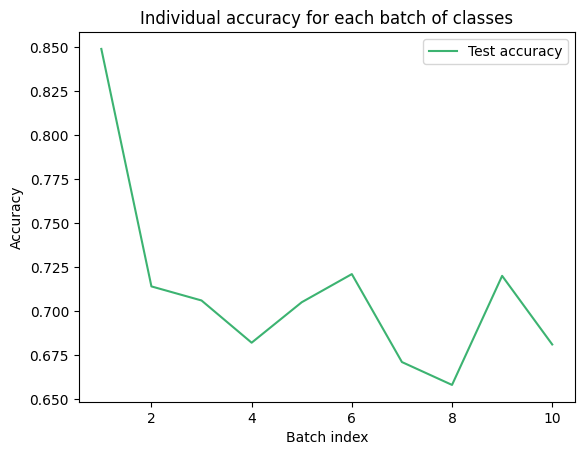

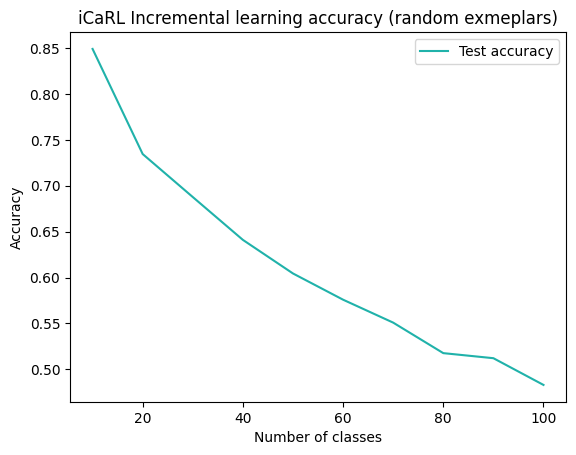

In [20]:
plot2(accuracy_new, accuracy_all,parameters)

In [ ]:
model = iCaRL(memory=10000, params = parameters)
accuracy_new, accuracy_all = model.run(herding = True)

In [ ]:
plot2(accuracy_new, accuracy_all)